# Mapping the Ionosphere with Millions of Phones

This notebook demonstrates the method to process global phone measurements into a detailed ionosphere map and visualize it.

Smith, J., Kast, A., Geraschenko, A. et al. Mapping the ionosphere with millions of phones. Nature 635, 365–369 (2024). https://doi.org/10.1038/s41586-024-08072-x

In [ ]:
# Install dependencies.
! apt install -qq libsuitesparse-dev
! pip install -q apache_beam cartopy georinex numpy s2sphere scikit-sparse

In [ ]:
# Get the library of ionosphere code.
!git clone https://github.com/google/ionosphere

In [ ]:
# Download all the files needed from Code Ocean https://doi.org/10.24433/CO.9149928.v1
!mkdir data
!mkdir data/vtec_maps

!wget https://files.codeocean.com/files/verified/ec6fe27c-d523-4b43-bf5b-a5a046b49f03_v1.1/data/CAS0OPSRAP_20233090000_01D_01D_DCB.BIA.gz -O data/CAS0OPSRAP_20233090000_01D_01D_DCB.BIA.gz
!wget https://files.codeocean.com/files/verified/ec6fe27c-d523-4b43-bf5b-a5a046b49f03_v1.1/data/dcb_clusters.csv.gz -O data/dcb_clusters.csv.gz
!wget https://files.codeocean.com/files/verified/ec6fe27c-d523-4b43-bf5b-a5a046b49f03_v1.1/data/sat_xyz.csv.gz -O data/sat_xyz.csv.gz
!wget https://files.codeocean.com/files/verified/ec6fe27c-d523-4b43-bf5b-a5a046b49f03_v1.1/data/TLSE00FRA_R_20233090000_01D_30S_MO.crx.gz -O data/TLSE00FRA_R_20233090000_01D_30S_MO.crx.gz
!wget https://files.codeocean.com/files/verified/ec6fe27c-d523-4b43-bf5b-a5a046b49f03_v1.1/data/worldpop_population_per_km2_s2level10.csv.gz -O data/worldpop_population_per_km2_s2level10.csv.gz
!wget https://files.codeocean.com/files/verified/ec6fe27c-d523-4b43-bf5b-a5a046b49f03_v1.1/data/vtec_maps/vtec_2023_11_05.csv.gz?download -O data/vtec_maps/vtec_2023_11_05.csv.gz
!wget https://files.codeocean.com/files/verified/ec6fe27c-d523-4b43-bf5b-a5a046b49f03_v1.1/data/vtec_maps/vtec_2023_10_14.csv.gz?download -O data/vtec_maps/vtec_2023_10_14.csv.gz

In [ ]:
import cartopy
from cartopy import crs
import georinex
import jax
import matplotlib as mpl
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import s2sphere as s2
import seaborn as sns
import plotly.graph_objects as go
import warnings

import ionosphere.iono_lib as iono_lib

jax.config.update("jax_enable_x64", True)
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore', message='.*Downloading.*ne_110m_coastline.zip.*')

# Load VTEC maps for one day

In [ ]:
with open('data/vtec_maps/vtec_2023_11_05.csv.gz', 'rb') as f:
  raw_one_day_vtec_df = pd.read_csv(f, compression='gzip')
raw_one_day_vtec_df

In [ ]:
def set_extra_vtec_df_columns(vtec_df):
  # Convert unix epoch utc_sec to more human readable forms for plotting.
  vtec_df['timestamp'] = pd.to_datetime(vtec_df['utc_sec'], unit='s', utc=True)
  vtec_df['date_and_time'] = vtec_df['timestamp'].dt.strftime('%Y_%m_%d_T_%H_%M_%S')

  # Convert S2 tokens into S2CellId objects.
  s2_cell_ids = [s2.CellId.from_token(x) for x in vtec_df['pierce_s2_token']]
  vtec_df['pierce_s2_cell_id'] =  s2_cell_ids
  # Get the central latitude and longitude of the S2 quadrilateral.
  # This is the ionosphere pierce point.
  latlngs = [c.to_lat_lng() for c in s2_cell_ids]
  lat_deg = [latlng.lat().degrees for latlng in latlngs]
  lng_deg = [latlng.lng().degrees for latlng in latlngs]
  vtec_df['pierce_lng'] =  lng_deg
  vtec_df['pierce_lat'] = lat_deg
  return vtec_df

one_day_vtec_df = set_extra_vtec_df_columns(raw_one_day_vtec_df)
one_day_vtec_df

# Select one timeslice from the day of VTEC maps and plot it

In [ ]:
one_time_vtec_df = one_day_vtec_df.query('date_and_time == "2023_11_05_T_20_00_00"')

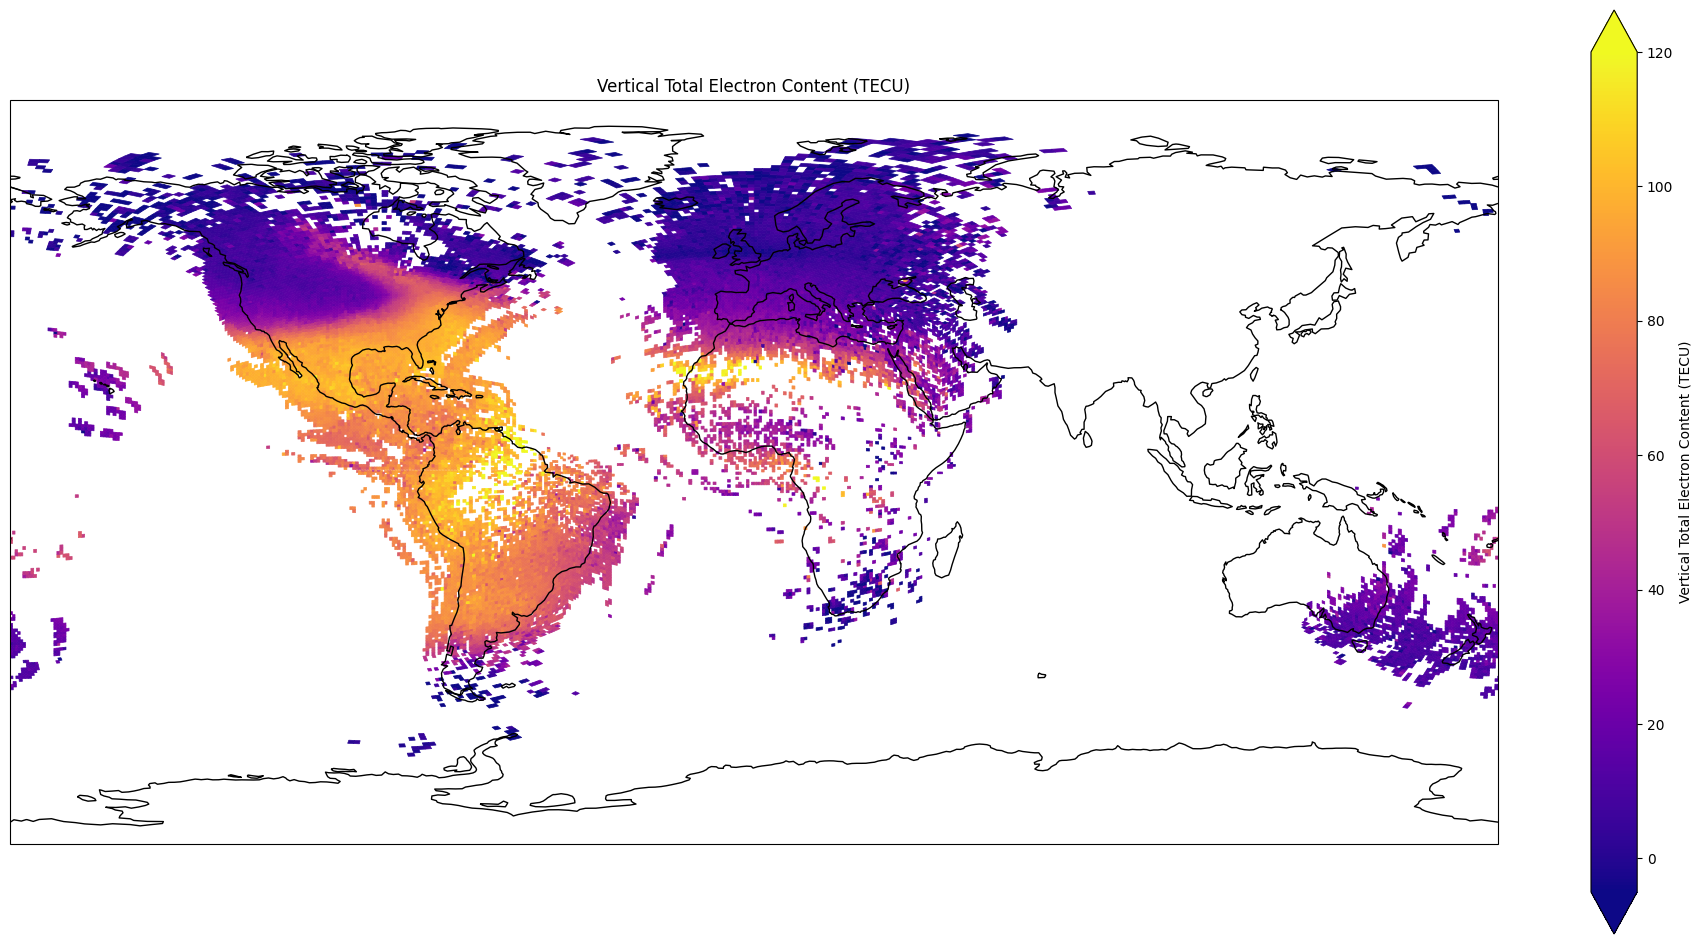

In [ ]:
def plot_ionosphere_vtec(vtec_df, vmin=-5, vmax=120, cmap='plasma'):
  fig, ax = plt.subplots(
      figsize=(24, 12),
      subplot_kw=dict(projection=crs.PlateCarree(central_longitude=0)))
  norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
  cmap = mpl.colormaps.get_cmap(cmap)

  cells = [s2.S2CellId.from_token(x) for x in vtec_df['pierce_s2_token']]
  patches = [mpl.patches.Polygon(iono_lib._cell_id_to_vertices(x)) for x in cells]
  p = mpl.collections.PatchCollection(patches,
                                      transform=cartopy.crs.Geodetic(),
                                      edgecolor='face',
                                      linewidth=0.5,
                                      norm=norm,
                                      cmap=cmap)
  p.set_array(vtec_df['vtec'])
  ax.add_collection(p)

  ax.coastlines()

  min_lng = -180
  max_lng = 180
  min_lat = -90
  max_lat = 90
  ax.set_xlim((min_lng, max_lng))
  ax.set_ylim((min_lat, max_lat))
  ax.set_title('Vertical Total Electron Content (TECU)')

  fig.colorbar(
      mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
      label='Vertical Total Electron Content (TECU)',
      ax=ax,
      orientation='vertical',
      extend='both',
  )
  return fig, ax

_ = plot_ionosphere_vtec(one_time_vtec_df)

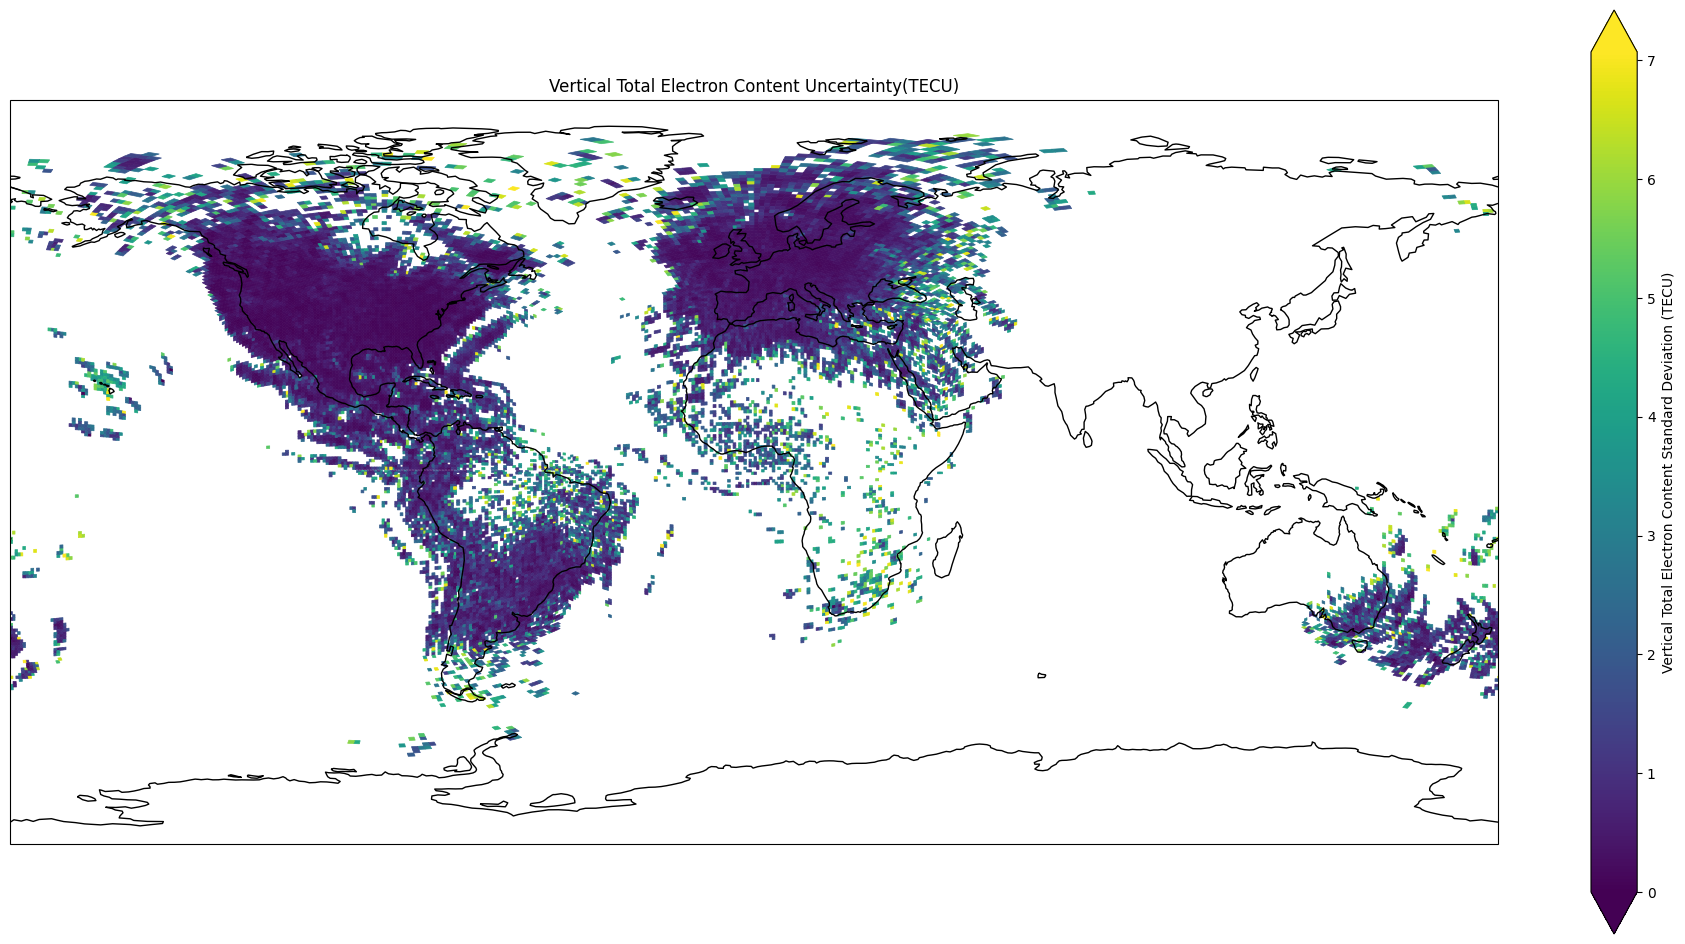

In [ ]:
def plot_ionosphere_vtec_stddev(vtec_df, vmin=0, vmax=np.sqrt(50), cmap='viridis'):
  fig, ax = plt.subplots(
      figsize=(24, 12),
      subplot_kw=dict(projection=crs.PlateCarree(central_longitude=0)))
  norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
  cmap = mpl.colormaps.get_cmap(cmap)

  cells = [s2.S2CellId.from_token(x) for x in vtec_df['pierce_s2_token']]
  patches = [mpl.patches.Polygon(iono_lib._cell_id_to_vertices(x)) for x in cells]
  p = mpl.collections.PatchCollection(patches,
                                      transform=cartopy.crs.Geodetic(),
                                      edgecolor='face',
                                      linewidth=0.5,
                                      norm=norm,
                                      cmap=cmap)
  p.set_array(vtec_df['vtec_stddev'])
  ax.add_collection(p)

  ax.coastlines()

  min_lng = -180
  max_lng = 180
  min_lat = -90
  max_lat = 90
  ax.set_xlim((min_lng, max_lng))
  ax.set_ylim((min_lat, max_lat))
  ax.set_title('Vertical Total Electron Content Uncertainty(TECU)')

  fig.colorbar(
      mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
      label='Vertical Total Electron Content Standard Deviation (TECU)',
      ax=ax,
      orientation='vertical',
      extend='both',
  )
  return fig, ax

_ = plot_ionosphere_vtec_stddev(one_time_vtec_df)

# Use VTEC map to predict the STEC for a line-of-sight between a receiver and a satellite

In [ ]:
# The methods used allow for many lines-of-sight to be queried in parallel using
# arrays but for clarity, we demonstrate using a single line-of-sight.


# The receiver position in Earth-centered, Earth-fixed (c) coordinates.
rcv_xyz = np.array(
    [[4625572.5197623 ,  113436.3149125 , 4375251.94929245]])

# The satellite position in Earth-centered, Earth-fixed coordinates.
sat_xyz = np.array(
    [[4003055.697494988, -27330587.703980755, 10638501.656612676]])

# Calculate the ionosphere piercing point in ECEF coordinates.
pierce_xyz = iono_lib.pierce_point(
    rcv_xyz, sat_xyz, iono_lib.IONOSPHERE_ELLIPSOID)
print(f'{pierce_xyz=}')

# Determine the piercing point S2 Cell. First, convert to latitude/longitude.
pierce_lng, pierce_lat, _ = iono_lib.xyz_to_lng_lat_elevation(
    pierce_xyz, iono_lib.IONOSPHERE_ELLIPSOID
)
# Then, convert latitude and longitude to an S2 Token.
pierce_s2_token = iono_lib.lng_lat_to_token_at_level(
    pierce_lng, pierce_lat, s2_level=iono_lib.IONOSPHERE_S2_LEVEL
)
print(f'{pierce_s2_token=}')

# Use the piercing point S2 token to query the map for the VTEC at that place.
indexed_vtec_df = one_time_vtec_df.set_index(
    'pierce_s2_token', verify_integrity=True)
vtec_at_pierce_point = indexed_vtec_df.loc[pierce_s2_token, 'vtec'].values
print(f'{vtec_at_pierce_point=}')

# Calculate the slant factor at the piercing point.
slant_factor_value = iono_lib.slant_factor(
    pierce_xyz, sat_xyz, iono_lib.IONOSPHERE_ELLIPSOID
)
print(f'{slant_factor_value=}')

# Use the slant factor to convert from VTEC to STEC.
predicted_stec = vtec_at_pierce_point * slant_factor_value
print(f'{predicted_stec=}')

pierce_xyz=Array([[ 4592197.94698144, -1357901.55782505,  4711039.31394599]],      dtype=float64)
pierce_s2_token=['49de4']
vtec_at_pierce_point=array([19.468])
slant_factor_value=Array([2.95993843], dtype=float64)
predicted_stec=Array([57.62408136], dtype=float64)


# Create a dataset of synthetic measurements

To demonstrate the method to fit ionosphere maps using phone measurements, a synthetic dataset is used. The synthetic measurements are chosen to match the
real distribution of phone measurements in terms of receiver location, satellites observed and measurement noise. The ionosphere map already loaded is used to set the measured values before noise is added. Using these synthetic measurements, the ionosphere map is then re-estimated.

In [ ]:
# We will use the VTEC map to simulate measurements from phones at that time.
utc_sec = one_time_vtec_df['utc_sec'].unique()
assert len(utc_sec) == 1
utc_sec = utc_sec[0]
utc_sec

1699214400

In [ ]:
# Load the satellite positions for this time.
# Satellite positions are determined from published orbit parameters.
# For convenience, a file is included with the satellite positions at this time.
with open('data/sat_xyz.csv.gz', 'rb') as f:
  full_sat_xyz_df = pd.read_csv(f, compression='gzip')
  full_sat_xyz_df = full_sat_xyz_df.set_index(
      ['utc_sec', 'sv'], verify_integrity=True)

sat_xyz_df = full_sat_xyz_df.loc[utc_sec]
sat_xyz_df

In [ ]:
# Use population density to select realistic phone locations.
# The underlying population density data is courtesy of www.worldpop.org
# It has been processed to get the population density in each S2 Level 10 cell.

with open('data/sat_xyz.csv.gz', 'rb') as f:
  population_density_df = pd.read_csv(
      'data/worldpop_population_per_km2_s2level10.csv.gz', compression='gzip')
population_density_df

In [ ]:
# Load the clusters of Differential Code Bias (DCB) seen in phones.
# Which cluster a phone is in depends on the model of the phone.
# We will set the DCB for simulated phones by sampling from these clusters.
with open('data/sat_xyz.csv.gz', 'rb') as f:
  dcb_clusters_df = pd.read_csv(
      'data/dcb_clusters.csv.gz', compression='gzip')
dcb_clusters_df

In [ ]:
def generate_synthetic_measurements(
    utc_sec,
    population_density_df,
    dcb_clusters_df,
    vtec_df,
    rng,
    ) -> pd.DataFrame:
  # Make a dataframe of one row per receiver. Has location and DCB values.
  rcv_df = iono_lib.generate_phones_at_locations(
      utc_sec,
      population_density_df,
      dcb_clusters_df,
      rng)

  # Make a dataframe with a row for each line-of-sight between satellites and
  # locations on the ground where there are receivers.
  los_df = iono_lib.get_los_df(sat_xyz_df, rcv_df.coarse_rcv_s2_id)
  los_df = iono_lib.set_pierce_point_cols(los_df)
  los_df = iono_lib.set_stec_true(vtec_df, los_df)

  # Merge the dataframes to get one row per measurements along each line of
  # sight for each receiver.
  meas_df = pd.merge(rcv_df, los_df, on='coarse_rcv_s2_id', how='inner')
  meas_df = iono_lib.set_measurement_values(meas_df, rng)
  meas_df['utc_sec'] = utc_sec
  meas_df['timestamp'] = pd.to_datetime(meas_df['utc_sec'], unit='s', utc=True)

  # Choose the columns to return.
  meas_df = meas_df[[
      'utc_sec',
      'timestamp',
      'sv',
      'constellation',
      'higher_frequency_hz',
      'lower_frequency_hz',
      'sat_lng',
      'sat_lat',
      'sat_x',
      'sat_y',
      'sat_z',
      'coarse_rcv_s2_id',
      'rcv_lng',
      'rcv_lat',
      'rcv_x',
      'rcv_y',
      'rcv_z',
      'source_id',
      'stec',
      'stec_stddev',
      'pierce_lng',
      'pierce_lat',
      'slant_factor',
      'elev_angle_deg',
      'rcv_dcb_tecu_true',
      'vtec_true',
      'stec_true',
      'stec_noise_true',
  ]]

  return meas_df

meas_df = generate_synthetic_measurements(
    utc_sec,
    population_density_df,
    dcb_clusters_df,
    one_time_vtec_df,
    np.random.default_rng(0)  # Set the random seed for reproducible results.
    )
meas_df

# Measurement dataframe field descriptions

| Column Name  | Units  | Description |
| -------- | -------- | ------- |
| utc_sec | seconds | Time in UTC that the measurement was made. Seconds since unix epoch. Measurements over each minute have been averaged and the midpoint is given as the timestamp.|
| sv | | Identifier for the satellite for the measurement. "sv" stands for space vehicle. |
| constellation | | Constellation of the satellite. We use the American GPS and the European Galileo system.|
| higher_frequency_hz | Hz | The higher of the two radio frequencies in a dual-frequency ionosphere measurement (in Hertz). We use the "L1" carrier frequency. |
| lower_frequency_hz | Hz | The lower of the two radio frequencies in a dual-frequency ionosphere measurement (in Hertz). We use the "L5" carrier frequency. |
| sat_lng | degrees | Satellite ground track position's longitude in degrees. Used only for visualization. |
| sat_lat | degrees | Satellite ground track position's latitude in degrees. Used only for visualization. |
| sat_x | meters | Satellite x coordinate in the ECEF reference frame. |
| sat_y | meters | Satellite y coordinate in the ECEF reference frame. |
| sat_z | meters | Satellite z coordinate in the ECEF reference frame. |
| coarse_rcv_s2_id | |  Coarse (level 10) S2 cell that the receiver (phone) is located within. |
| rcv_lng | degrees | Longitude in degrees of the center of the coarse s2 cell that the receiver is located within. |
| rcv_lat | degrees | Latitude in degrees of the center of the coarse s2 cell that the receiver is located within. |
| rcv_x | meters | The x coordinate in the ECEF reference frame for the center of the coarse s2 cell that the receiver is located within. |
| rcv_y | meters | The y coordinate in the ECEF reference frame for the center of the coarse s2 cell that the receiver is located within. |
| rcv_z | meters | The z coordinate in the ECEF reference frame for the center of the coarse s2 cell that the receiver is located within. |
| source_id | | Identifier for the receiver. |
| stec | TECU | Measured value for the Slant Total Electron Content in TEC Units. The receiver bias and noise is present in this measurement value.|
| stec_stddev | TECU | Standard deviation of the measurement of the Slant Total Electron Content in TEC Units.|
| pierce_lng | degrees | Longitude in degrees of the Ionosphere Piercing Point along the line from the satellite to the center of the coarse s2 cell that the receiver is located within. |
| pierce_lat | degrees | Latitude in degrees of the Ionosphere Piercing Point along the line from the satellite to the center of the coarse s2 cell that the receiver is located within. |
| slant_factor |  | Conversion factor between vertical and slant TEC measurement based on the angle between the line-of-sight and the ionosphere. |
| elev_angle_deg | degrees | Elevation angle in degrees. How high the satellite appears in the sky when viewed from the receiver's position. |
| rcv_dcb_tecu_true | TECU | The true receiver differential code bias. The true value is known for synthetic measurements. |
| vtec_true | TECU | The true Vertical Total Electron Content at the Ionosphere Piercing Point. The true value is known because the measurements are synthetic. |
| stec_true | TECU | The true Slant Total Electron Content along the path from satellite to receiver. The true value is known because the measurements are synthetic. |
| stec_noise_true | TECU  | The true measurement noise for the Slant Total Electron Content along the path from satellite to receiver. The true value is known because the measurements are synthetic |

# Plot number of measurements at each coarse location

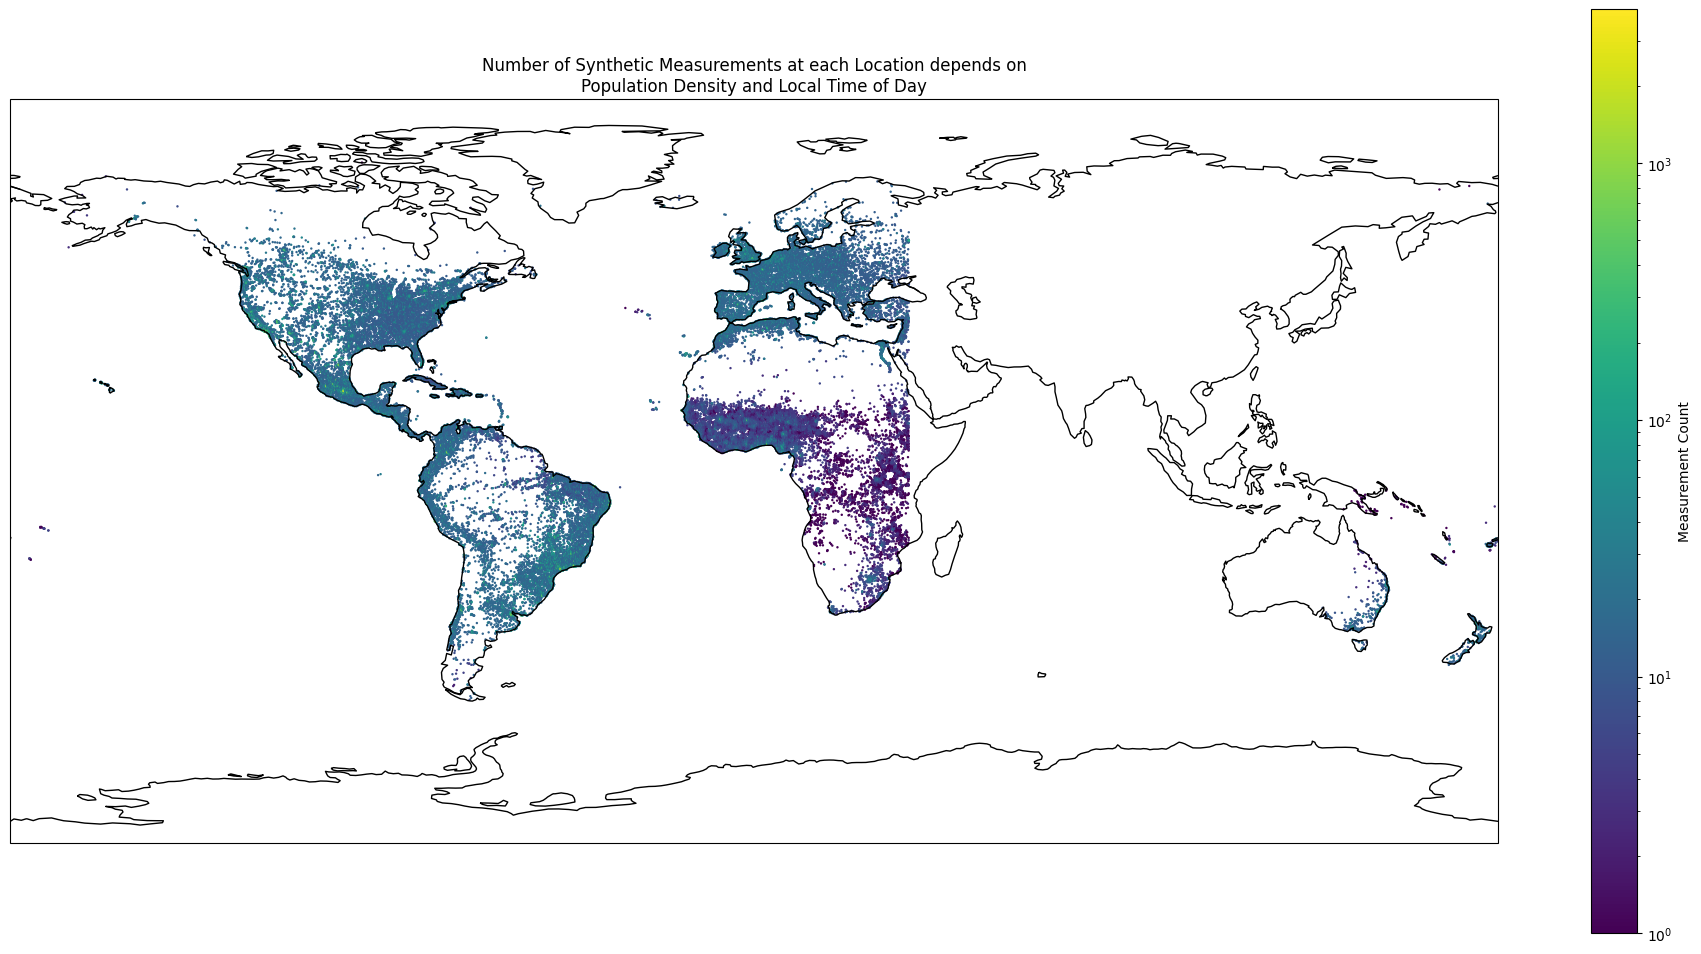

In [ ]:
def plot_location_measurement_counts(location_measurement_counts_df):
  values = location_measurement_counts_df['Measurement Counts'].values
  fig, ax = plt.subplots(
      figsize=(24, 12),
      subplot_kw=dict(projection=crs.PlateCarree(central_longitude=0)))
  vmin = min(values)
  vmax = max(values)
  palette = 'viridis'
  norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
  sns.scatterplot(location_measurement_counts_df,
                  x='rcv_lng',
                  y='rcv_lat',
                  linewidth=0,
                  s=3,
                  ax=ax,
                  hue=values,
                  hue_norm=norm,
                  palette=palette,
                  legend=False)
  ax.coastlines()
  ax.set_xlim((-180, 180))
  ax.set_ylim((-90, 90))
  ax.set_title('Number of Synthetic Measurements at each Location depends on\nPopulation Density and Local Time of Day')
  plt.colorbar(
      mpl.cm.ScalarMappable(norm=norm, cmap=palette),
      ax=ax,
      label='Measurement Count',
  )
  return fig, ax

location_measurement_counts_df = (
    meas_df.groupby(['rcv_lng', 'rcv_lat'])
    .size()
    .to_frame('Measurement Counts')
    .reset_index())

_ = plot_location_measurement_counts(location_measurement_counts_df)

# Fit the ionosphere and receiver biases using the measurements

In [ ]:
vtec_df, rcv_dcb_df = iono_lib.fit_ionosphere_from_measurements(meas_df)

In [ ]:
vtec_df

In [ ]:
rcv_dcb_df

# Plot the ionosphere VTEC map estimated from the measurements

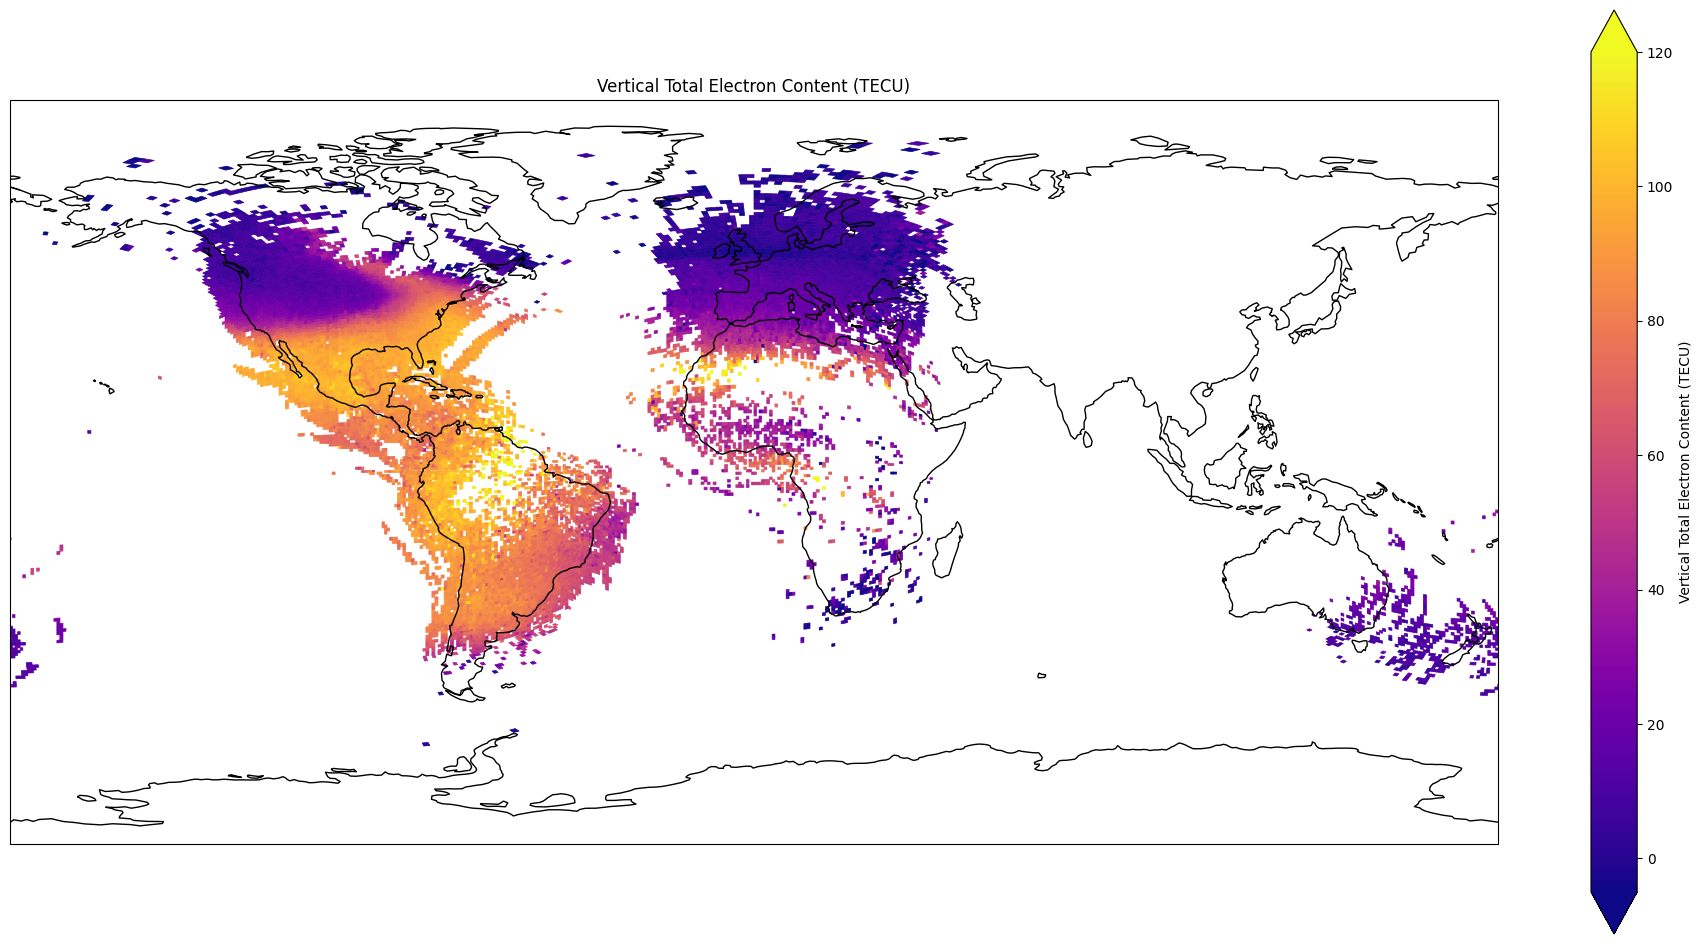

In [ ]:
_ = plot_ionosphere_vtec(vtec_df)

# Plot the estimated receiver biases

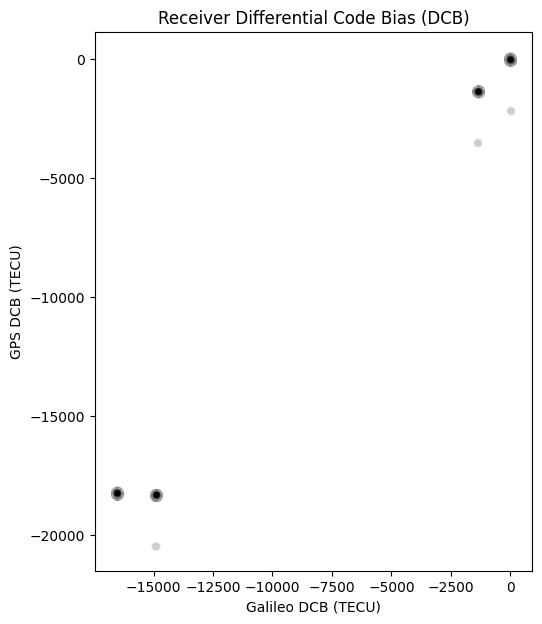

In [ ]:
def plot_receiver_bias_estimates(rcv_dcb_df):
  pivoted_rcv_dcb_df = pd.pivot(rcv_dcb_df,
                                index='source_id',
                                columns='constellation',
                                values='rcv_dcb_tecu')
  fig = plt.figure(figsize=(7, 7))
  ax = sns.scatterplot(pivoted_rcv_dcb_df,
                       x='GALILEO',
                       y='GPS',
                       color='k',
                       alpha=0.1)
  ax.set_aspect('equal', 'box')
  ax.set_xlabel('Galileo DCB (TECU)')
  ax.set_ylabel('GPS DCB (TECU)')
  ax.set_title('Receiver Differential Code Bias (DCB)')
  return fig, ax

_ = plot_receiver_bias_estimates(rcv_dcb_df)

# Use the estimated receiver biases to correct raw STEC measurements

In [ ]:
debiased_meas_df = pd.merge(meas_df, rcv_dcb_df, on=['source_id', 'constellation'], how='inner')
debiased_meas_df['debiased_stec'] = debiased_meas_df['stec'] - debiased_meas_df['rcv_dcb_tecu']
debiased_meas_df

# Plot de-biased STEC measurements from receivers in New York


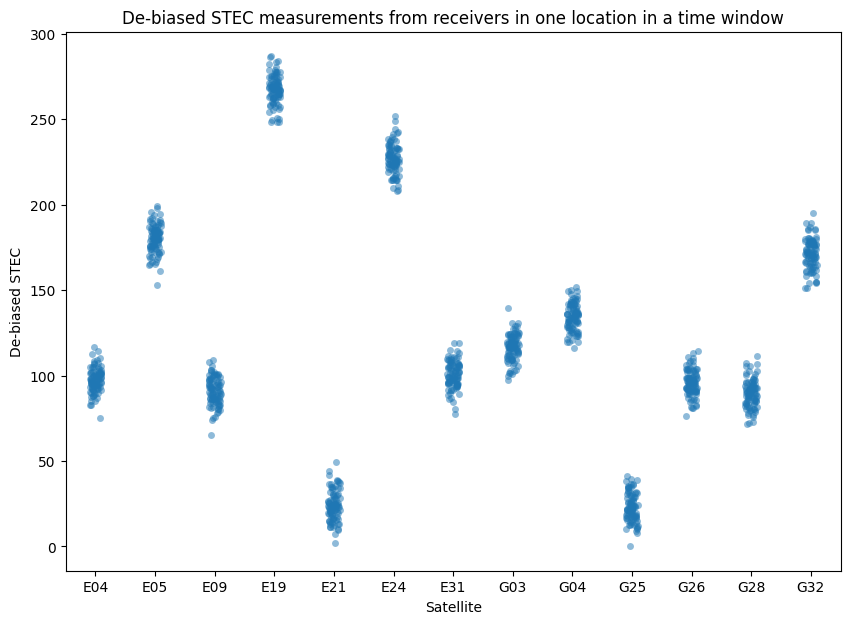

In [ ]:
new_york_id = iono_lib.coarse_id_from_lat_lng_deg(40.77806, -73.96865)
new_york_debiased_meas_df = debiased_meas_df[
    debiased_meas_df.coarse_rcv_s2_id == new_york_id].copy()

plt.figure(figsize=(10, 7))
sns.stripplot(
    new_york_debiased_meas_df,
    x='sv',
    y='debiased_stec',
    order=sorted(new_york_debiased_meas_df.sv.unique()),
    alpha=0.5,
)
plt.xlabel('Satellite')
plt.ylabel('De-biased STEC')
plt.title('De-biased STEC measurements from receivers in one location in a time window')
plt.show()

# Show elevation angle to the satellite in the sky for the receiver location

In [ ]:
sv_and_elev = new_york_debiased_meas_df.groupby('sv')['elev_angle_deg'].mean().to_frame()
sv_and_elev.T.style.background_gradient(axis=1, vmin=0, vmax=90).format("{:.1f}")

sv,E04,E05,E09,E19,E21,E24,E31,G03,G04,G25,G26,G28,G32
elev_angle_deg,67.1,5.3,57.5,8.9,7.6,14.5,63.8,40.5,24.9,7.1,73.7,51.8,27.0


# Plot coarse receiver location and satellite positions

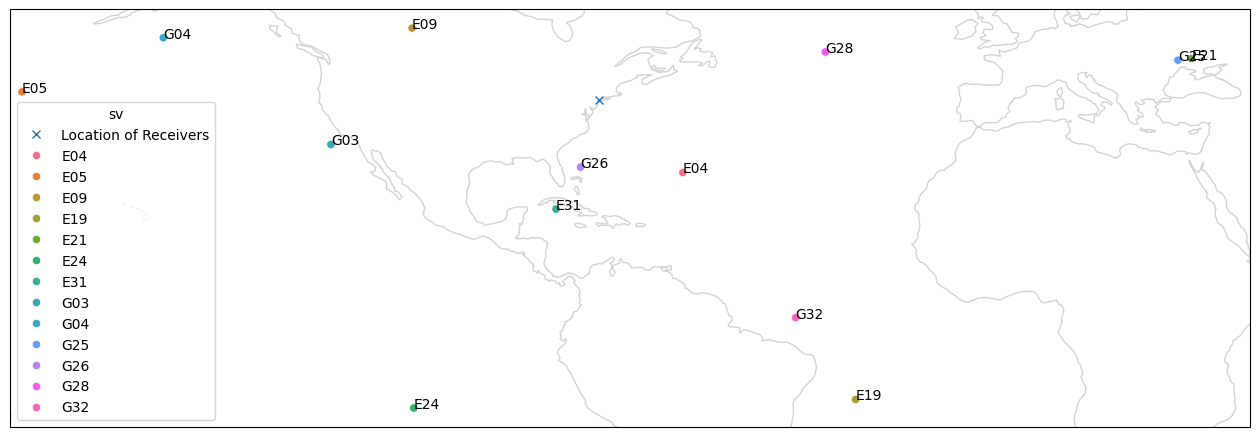

In [ ]:
def plot_sats_at_one_rcv_location(one_loc_meas_df):
  fig, ax = plt.subplots(
      figsize=(16, 8),
      subplot_kw=dict(projection=crs.PlateCarree(central_longitude=0)))
  ax.coastlines(color='lightgrey')
  one_coarse_rcv_s2_id = one_loc_meas_df.coarse_rcv_s2_id.unique()
  if len(one_coarse_rcv_s2_id) != 1:
    raise ValueError(
        'Intended for use with receivers in one location. '
        'coarse_rcv_s2_id must be unique')
  one_coarse_rcv_s2_id = one_coarse_rcv_s2_id[0]
  receivers_coarse_latlng = s2.S2CellId(int(one_coarse_rcv_s2_id)).to_lat_lng()
  plt.plot(
      receivers_coarse_latlng.lng().degrees,
      receivers_coarse_latlng.lat().degrees,
      'x',
      label='Location of Receivers')

  sv_order = list(sorted(one_loc_meas_df.sv.unique()))
  sns.scatterplot(
      one_loc_meas_df,
      x='sat_lng',
      y='sat_lat',
      hue='sv',
      hue_order=sv_order,
      ax=ax)
  mean_sat = one_loc_meas_df.groupby('sv')[['sat_lat', 'sat_lng']].mean()
  for sv, (sat_lat, sat_lng) in mean_sat.iterrows():
    ax.text(sat_lng, sat_lat, sv, label=None)

  return fig, ax

_ = plot_sats_at_one_rcv_location(new_york_debiased_meas_df)
plt.show()

# Choose phone measurements from Toulouse France where there is a nearby monitoring station for comparison

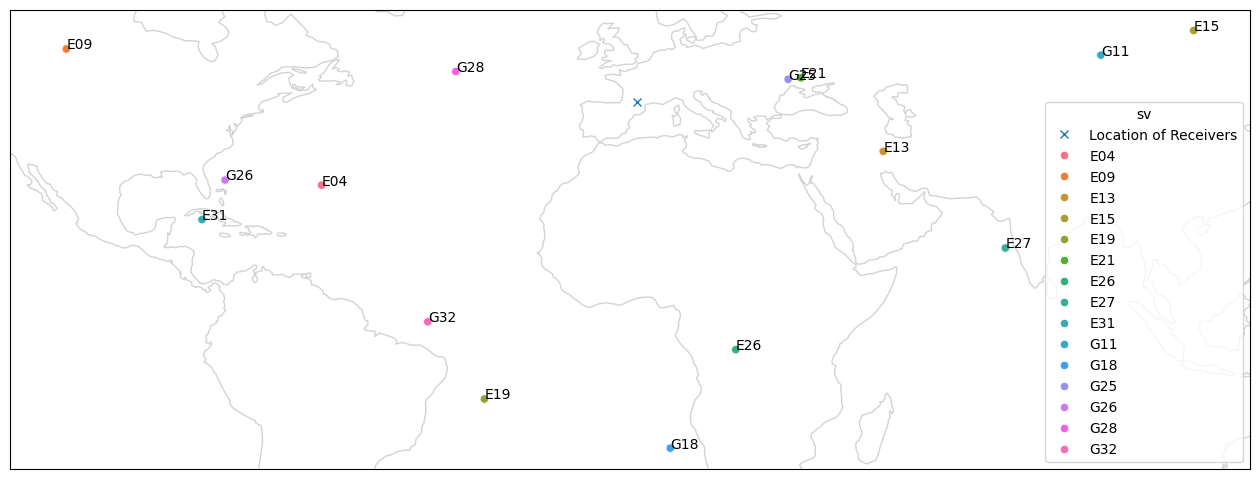

In [ ]:
toulouse_id = iono_lib.coarse_id_from_lat_lng_deg(43.598308, 1.438335) # Toulouse, France
toulouse_debiased_meas_df = debiased_meas_df[
    debiased_meas_df.coarse_rcv_s2_id == toulouse_id].copy()

_ = plot_sats_at_one_rcv_location(toulouse_debiased_meas_df)
plt.show()

# Load measurements from a nearby monitoring station in Toulouse

We use one of the IGS monitoring stations.

https://network.igs.org/TLSE00FRA

The file was retrieved with the following command:

`wget --ftp-user anonymous --ftp-password anon@example.com ftps://gdc.cddis.eosdis.nasa.gov/gnss/data/daily/2023/309/23d/TLSE00FRA_R_20233090000_01D_30S_MO.crx.gz`


In [ ]:
raw_station_ds = georinex.load('data/TLSE00FRA_R_20233090000_01D_30S_MO.crx.gz',
                               tlim=['2023-11-05T19:55', '2023-11-05T20:05'])
raw_station_df = raw_station_ds.to_dataframe()
raw_station_df

# Load the published satellite and station biases for that day

The satellite and station biases are published by IGS.

https://igs.org/mgex/

The file was retrieved with the following command:

`wget --ftp-user anonymous --ftp-password anon@example.com ftps://gdc.cddis.eosdis.nasa.gov/gnss/products/mgex/dcb/2023/CAS0OPSRAP_20233090000_01D_01D_DCB.BIA.gz`


In [ ]:
published_bias_df = pd.read_fwf(
    'data/CAS0OPSRAP_20233090000_01D_01D_DCB.BIA.gz',
    compression='gzip',
    skiprows=58,
    skipfooter=2
    )
published_bias_df

In [ ]:
# Example of bias lookup. Station TLSE bias for GPS satellites between codes C1C and C5X
published_bias_df.query((
    'STATION__ == "TLSE" and '
    'OBS1=="C1C" and '
    'OBS2=="C5X" and '
    'PRN =="G"'))

# Use the station measurements and the biases to get calibrated station STEC measurements

In [ ]:
selected_svs = list(sorted(toulouse_debiased_meas_df.sv.unique()))
selected_gps_svs = [x for x in selected_svs if x.startswith('G')]
selected_gal_svs = [x for x in selected_svs if x.startswith('E')]

station_gal_df = iono_lib.process_station_measurements(
    raw_station_df,
    selected_gal_svs,
    'C1X',
    'C5X',
    published_bias_df,
    'TLSE',
    'E'
    )

station_gps_df = iono_lib.process_station_measurements(
    raw_station_df,
    selected_gps_svs,
    'C1C',
    'C5X',
    published_bias_df,
    'TLSE',
    'G'
)
station_df = pd.concat([station_gal_df, station_gps_df])
station_df['utc_sec'] = station_df['time'].apply(lambda x: x.timestamp())
station_df

# Plot STEC measurements from monitoring station and nearby phones

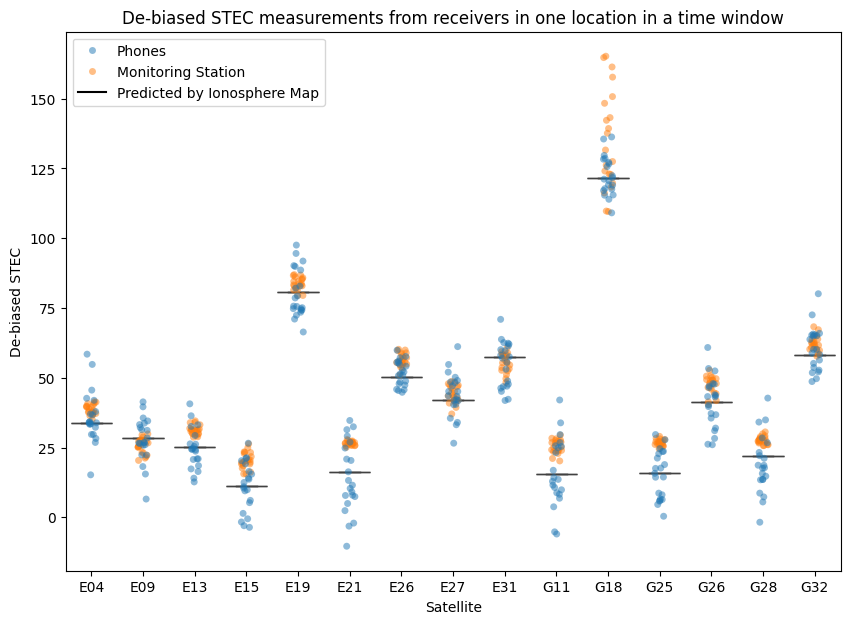

In [ ]:
# Concatenate the station and phone measurements together for plotting.
station_and_phones_df = pd.concat([
    station_df[['sv', 'debiased_stec', 'utc_sec']].assign(Source='Monitoring Station'),
    toulouse_debiased_meas_df[['sv', 'debiased_stec', 'utc_sec']].assign(Source='Phones')])

plt.figure(figsize=(10, 7))
svs = list(sorted(station_and_phones_df.sv.unique()))
ax = sns.stripplot(
    station_and_phones_df,
    x='sv',
    y='debiased_stec',
    order=svs,
    hue='Source',
    hue_order=('Phones', 'Monitoring Station'),
    alpha=0.5,
)
sns.boxplot(
    toulouse_debiased_meas_df,
    order=svs,
    x='sv',
    y='stec_true',
)
handles, labels = ax.get_legend_handles_labels()
handles = handles + [mpl.lines.Line2D([0], [0], color='k')]
labels = labels + ['Predicted by Ionosphere Map']
ax.legend(handles=handles, labels=labels)
plt.xlabel('Satellite')
plt.ylabel('De-biased STEC')
plt.title('De-biased STEC measurements from receivers in one location in a time window')
plt.show()

# Interactive 3D Visualization

In [ ]:
fig = go.Figure()
iono_lib.plot_ionosphere_vtec_3d(fig, vtec_df)
iono_lib.plot_coastlines(fig)
iono_lib.plot_sphere_front(fig)
iono_lib.plot_sphere_back(fig)
iono_lib.plot_line_of_sight(fig, toulouse_debiased_meas_df)
iono_lib.plot_satellite_positions(fig, sat_xyz_df)

fig.update_layout(
    height=800,
    width=800,
    margin=dict(l=5, r=5, t=5, b=5),
    scene = dict(
        xaxis = dict(visible=False),
        yaxis = dict(visible=False),
        zaxis =dict(visible=False),
        ),
    legend=dict(
        yanchor="bottom",
        y=0.01,
        xanchor="left",
        x=0.01
        ),
    )

# Scroll to zoom. Drag to rotate.
with open('interactive_globe.html', 'w') as f:
  fig.write_html(f)

# Animation of plasma bubbles over South Asia

In [ ]:
# Load the VTEC maps for a day with plasma bubbles.
with open('data/vtec_maps/vtec_2023_10_14.csv.gz', 'rb') as f:
  raw_vtec_2023_10_14_df = pd.read_csv(f, compression='gzip')
vtec_2023_10_14_df = set_extra_vtec_df_columns(raw_vtec_2023_10_14_df)
# Limit to the place and time of the plasma bubbles
min_lat= -30
min_lng= 65
max_lat= 30
max_lng= 125
limited_vtec_2023_10_14_df = vtec_2023_10_14_df.query(
    'pierce_lng >= @min_lng and pierce_lng <= @max_lng and '
    'pierce_lat >= @min_lat and pierce_lat <= @max_lat and '
    'timestamp >= "2023-10-14 09:00:00+00:00" and '
    'timestamp <= "2023-10-14 18:00:00+00:00"')

In [ ]:
def make_animation(vtec_over_time_df, min_lat, min_lng, max_lat, max_lng):
  # Pivot to have one row per timeslice for animation.
  pivoted_vtec_df = vtec_over_time_df.pivot(
      index='utc_sec', columns='pierce_s2_token', values='vtec')

  fig, ax = plt.subplots(
      figsize=(5,4),
      subplot_kw=dict(projection=crs.PlateCarree(central_longitude=0)))

  norm = mpl.colors.Normalize(vmin=-5, vmax=120)
  cmap = mpl.colormaps.get_cmap('plasma')
  cells = [s2.S2CellId.from_token(x) for x in pivoted_vtec_df.columns]
  patches = [
      mpl.patches.Polygon(iono_lib._cell_id_to_vertices(x)) for x in cells]
  p = mpl.collections.PatchCollection(patches,
                                      transform=cartopy.crs.Geodetic(),
                                      edgecolor='face',
                                      linewidth=0.5,
                                      norm=norm,
                                      cmap=cmap)
  ax.add_collection(p)
  ax.set_xlim((min_lng, max_lng))
  ax.set_ylim((min_lat, max_lat))
  ax.coastlines()
  fig.colorbar(
      mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
      label='Vertical Total Electron Content (TECU)',
      ax=ax,
      orientation='vertical',
      extend='both',
  )

  def animate(i):
    p.set_array(pivoted_vtec_df.iloc[i, :].values)

  anim = mpl.animation.FuncAnimation(
      fig, animate, frames=len(pivoted_vtec_df))
  plt.close()
  return anim

anim = make_animation(
    limited_vtec_2023_10_14_df,
    min_lat,
    min_lng,
    max_lat,
    max_lng)

with open('animation.html', 'w') as f:
  f.write(anim.to_jshtml())